In [3]:
import os
import cv2
import numpy as np

In [4]:
data = []
CATEGORIES = ["negatives", "positives"]

for category in CATEGORIES:
    path = category
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        
        data.append([img_array, class_num])
       

In [5]:
list_red_mean = []
list_green_mean = []
list_blue_mean = []
list_red_max = []
list_blue_max = []

new_data = []
for img, num in data:
    red_mean = 0
    green_mean = 0
    blue_mean = 0
    red_max = 0
    blue_max = 0
    green_min = 255
    red_min = 255
    for line in img:
        for pixel in line:
            red_mean += pixel[0]*(1/(img.shape[0]*img.shape[1]))
            green_mean += pixel[1]*(1/(img.shape[0]*img.shape[1]))
            blue_mean += pixel[2]*(1/(img.shape[0]*img.shape[1]))
            if pixel[0] > red_max:    
                red_max = pixel[0]
            if pixel[2] > blue_max:
                blue_max = pixel[2]
            if pixel[1] < green_min:
                green_min = pixel[1]
            if pixel[0] < red_min:
                red_min = pixel[0]    
    list_red_mean.append(red_mean)
    list_green_mean.append(green_mean)
    list_blue_mean.append(blue_mean)
    list_red_max.append(red_max)
    list_blue_max.append(blue_max)
    new_data.append([green_mean, blue_mean, red_max, blue_max, red_min, green_min, num])
    #new_data.append([red_mean, green_mean, blue_mean, red_max, blue_max, red_min, green_min, num])
    
num_features = len(new_data[0][-2:-len(new_data[0])-1:-1])

In [6]:
mü_0 = np.zeros((num_features,1))
mü_1 = np.zeros((num_features,1))
phi = 0
gamma = np.zeros((num_features,num_features))

for vec in new_data:
    phi += (1/len(new_data))*vec[num_features]
    if vec[num_features] == 0:    
        mü_0 += (1/30)*np.reshape(vec[0:num_features], (num_features,1))
    else:    
        mü_1 += (1/30)*np.reshape(vec[0:num_features], (num_features,1))
        
for vec in new_data:
    if vec[num_features] == 0:
        gamma += (1/60)*(np.reshape(vec[0:num_features], (num_features,1))-mü_0)@np.transpose(np.reshape(vec[0:num_features], (num_features,1))-mü_0)
    else:
        gamma += (1/60)*(np.reshape(vec[0:num_features], (num_features,1))-mü_1)@np.transpose(np.reshape(vec[0:num_features], (num_features,1))-mü_1)

# Parameters

In [7]:
print(mü_0)
print(mü_1)
print(gamma)

[[126.82800926]
 [163.71302083]
 [149.96666667]
 [187.03333333]
 [103.4       ]
 [102.8       ]]
[[139.52424769]
 [176.17256944]
 [165.33333333]
 [209.03333333]
 [104.73333333]
 [ 47.16666667]]
[[252.26656152 192.66638956 132.13186535 109.60448785 170.19188465
  176.06197242]
 [192.66638956 172.54299836 113.70731192 108.64623553 129.04273148
  118.72046296]
 [132.13186535 113.70731192 125.86055556 102.995       99.61777778
   70.63555556]
 [109.60448785 108.64623553 102.995      121.16555556  67.59777778
   48.43388889]
 [170.19188465 129.04273148  99.61777778  67.59777778 186.98444444
  133.87888889]
 [176.06197242 118.72046296  70.63555556  48.43388889 133.87888889
  221.08277778]]


In [8]:
def classify(x, mü_0, mü_1, gamma, phi):
    x = np.reshape(x, (len(x),1))
    p_x0 = (1/(2*(np.pi**(len(x)/2))*np.linalg.det(gamma)**(1/2)))*np.exp(-(1/2)*(np.transpose(x-mü_0)@np.linalg.inv(gamma))@(x-mü_0))
    p_x1 = (1/(2*(np.pi**(len(x)/2))*np.linalg.det(gamma)**(1/2)))*np.exp(-(1/2)*(np.transpose(x-mü_1)@np.linalg.inv(gamma))@(x-mü_1))    
    p_0 = (p_x0*(1-phi))/(p_x0*(1-phi)+p_x1*phi)
    p_1 = (p_x1*phi)/(p_x0*(1-phi)+p_x1*phi)
    if p_0 > p_1:
        return 0
    else:
        return 1

In [9]:
import random
k = 0
random.shuffle(new_data)
for dat in new_data:
    k += 1
    print(classify(dat[0:num_features], mü_0, mü_1, gamma, phi)-dat[-1])
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [51]:
from sklearn import svm

X = np.array(new_data)[:, 0:num_features]
y = np.array(new_data)[:, -1:-2:-1]
y = np.reshape(y, (y.shape[0],))

model = svm.SVC(C=1, kernel='rbf', degree=1, gamma=0.01, coef0=0)
model.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0,
    decision_function_shape='ovr', degree=1, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
prediction = model.predict(X)
loss = 0
for i in range(0,y.shape[0]):
    loss += (y[i]-prediction[i])**2
print(loss)

0.0


In [78]:
import matplotlib.pyplot as plt
C_ = np.arange(0.01,10,0.1)
gamma = np.arange(0.01,10,0.1)
data_grid = []
print(gamma)
for c in C_:
    for g in gamma:
        model = svm.SVC(C=c, kernel='sigmoid', degree=2, gamma=g, coef0=0)
        model.fit(X, y)
        prediction = model.predict(X)
        loss = 0
        for i in range(0,y.shape[0]):
            loss += (y[i]-prediction[i])**2
        data_grid.append([c, g, loss])

[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01 5.11 5.21 5.31 5.41 5.51
 5.61 5.71 5.81 5.91 6.01 6.11 6.21 6.31 6.41 6.51 6.61 6.71 6.81 6.91
 7.01 7.11 7.21 7.31 7.41 7.51 7.61 7.71 7.81 7.91 8.01 8.11 8.21 8.31
 8.41 8.51 8.61 8.71 8.81 8.91 9.01 9.11 9.21 9.31 9.41 9.51 9.61 9.71
 9.81 9.91]


In [79]:
data_grid = np.reshape(data_grid, (C_.shape[0], C_.shape[0], 3))
z = data_grid[:,:,2]
print(z)

[[30. 30. 30. ... 30. 30. 30.]
 [30. 30. 30. ... 30. 30. 30.]
 [30. 30. 30. ... 30. 30. 30.]
 ...
 [30. 30. 30. ... 30. 30. 30.]
 [30. 30. 30. ... 30. 30. 30.]
 [30. 30. 30. ... 30. 30. 30.]]


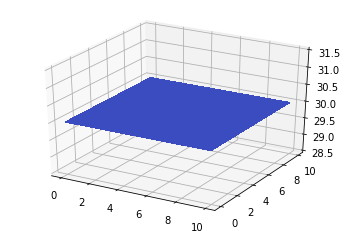

In [80]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
x = data_grid[:,:,0]
k = data_grid[:,:,1]
h = data_grid[:,:,2]

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, k, h, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [92]:
model = svm.SVC(C=1, kernel='linear', degree=4, gamma=1, coef0=0)
model.fit(X, y)
prediction = model.predict(X)
loss = 0
for i in range(0,y.shape[0]):
    loss += (y[i]-prediction[i])**2
print(loss)
print(model.support_vectors_)
print(model.n_support_)

0.0
[[137.13888889 169.24305556 165.         195.          96.
   94.        ]
 [115.03125    164.32638889 161.         193.         113.
   56.        ]
 [149.35069444 183.96354167 171.         210.         127.
   62.        ]
 [108.13020833 140.53993056 155.         197.          81.
   48.        ]
 [138.69444444 164.48090278 158.         190.         108.
   53.        ]]
[2 3]
